# Task : Forecast the mean temperature

In [1]:
#Importing libraries

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.api import qqplot
%matplotlib inline

In [2]:
#Loading given train and test data and setting date column as index
train_data_actual=pd.read_csv("DailyDelhiClimateTrain.csv")
train_data = train_data_actual.set_index('date')
test_data_actual=pd.read_csv("DailyDelhiClimateTest.csv")
test_data = test_data_actual.set_index('date')
test_data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [3]:
#fetching required column from dataframe
test_data=test_data[['meantemp']]
train_data=train_data[['meantemp']]

In [4]:
type(train_data)

pandas.core.frame.DataFrame

In [5]:
train_data.tail(6)

,meantemp
date,
2016-12-27,16.850000
2016-12-28,17.217391
2016-12-29,15.238095
2016-12-30,14.095238
2016-12-31,15.052632
2017-01-01,10.000000


Training Observations: 1462
Testing Observations: 114


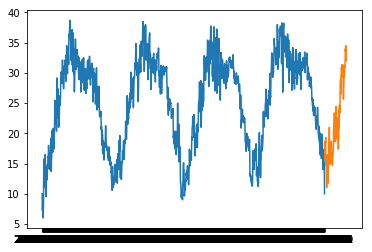

In [6]:
print('Training Observations: %d' % (len(train_data)))
print('Testing Observations: %d' % (len(test_data)))
plt.plot(train_data['meantemp'])
plt.plot([None for i in train_data['meantemp']] + [x for x in test_data['meantemp']])
plt.show()

In [7]:
train_data.isnull().sum()

meantemp    0
dtype: int64

In [8]:
train_data.dtypes, train_data.index.dtype

(meantemp    float64
 dtype: object, dtype('O'))

In [9]:
#since the index is string object, converting into datetime for time series analysis
train_data.index = pd.to_datetime(train_data.index)
test_data.index = pd.to_datetime(test_data.index)
train_data.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
               '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
               '2016-12-31', '2017-01-01'],
              dtype='datetime64[ns]', name='date', length=1462, freq=None)

In [10]:
train_data.describe()

,meantemp
count,1462.000000
mean,25.495521
std,7.348103
min,6.000000
25%,18.857143
50%,27.714286
75%,31.305804
max,38.714286


In [11]:
train_data.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


In [12]:
len(test_data)

114

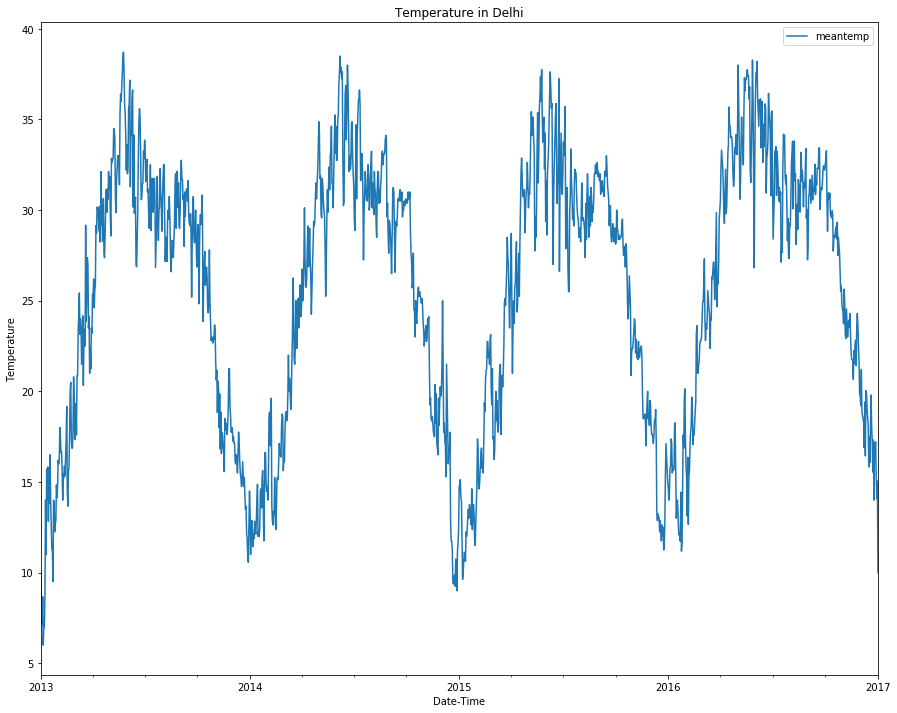

In [13]:
#visualizing data to see seasonality and trends
fig, ax = plt.subplots()
train_data.plot(figsize=(15,12),ax=ax)
ax.set_xlabel('Date-Time')
ax.set_ylabel('Temperature')
ax.set_title('Temperature in Delhi')
plt.show()

In [14]:
#visualizing monthly and yearly data
def plotAggregateValues_months(data,column=None):
    if column in data.columns:
        plt.figure(figsize = (18,35))
        ax2 = plt.subplot(4,2,2)
        data[column].groupby(data.index.month).mean().plot(ax=ax2,title='monthly mean values')
        ax2.set_xlabel('months')
        ax2.set_ylabel(column)


In [15]:
def plotAggregateValues_years(data,column=None):
    if column in data.columns:
        plt.figure()

        ax1 = plt.subplot(4,2,1)
        data[column].groupby(data.index.year).mean().plot(ax=ax1,title='yearly mean values')
        ax1.set_xlabel('years')
        ax1.set_ylabel(column)

        

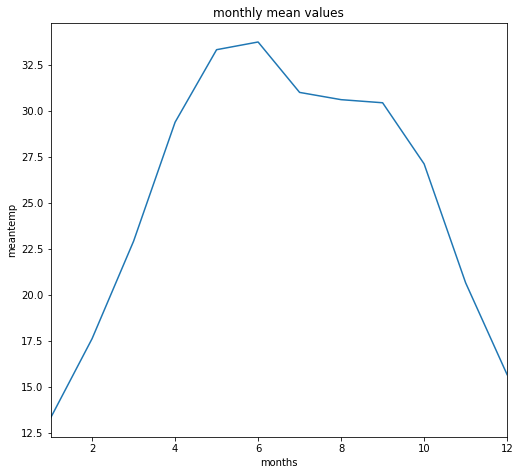

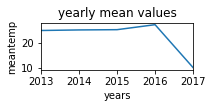

In [16]:
plotAggregateValues_months(train_data,'meantemp')
plotAggregateValues_years(train_data,'meantemp')

In [17]:
#On observing train and test data, data for 2017-01-01 is present in both train and test, removing this record from training data
train_data = train_data[:-1]

#We can see highest temperature during 5th & 6th month as it is summer time and low temperature during the end and start of the year because of winter.

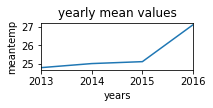

In [18]:
#we can see mean temp has increased slightly over the years
plotAggregateValues_years(train_data,'meantemp')

In [19]:
#Plotting box plot to check for outliers and distribution of data

def plotBoxNdendity(data,col=None):
    if col in data.columns:    
        plt.figure(figsize=(18,8))

        ax1 = plt.subplot(121)
        data.boxplot(col,ax=ax1)
        ax1.set_ylabel('Boxplot temperature levels in Delhi', fontsize=10)

        ax2 = plt.subplot(122)
        data[col].plot(ax=ax2,legend=True,kind='density')
        ax2.set_ylabel('Temperature distribution in Delhi', fontsize=10)

    else:
        print("Column not in the data")

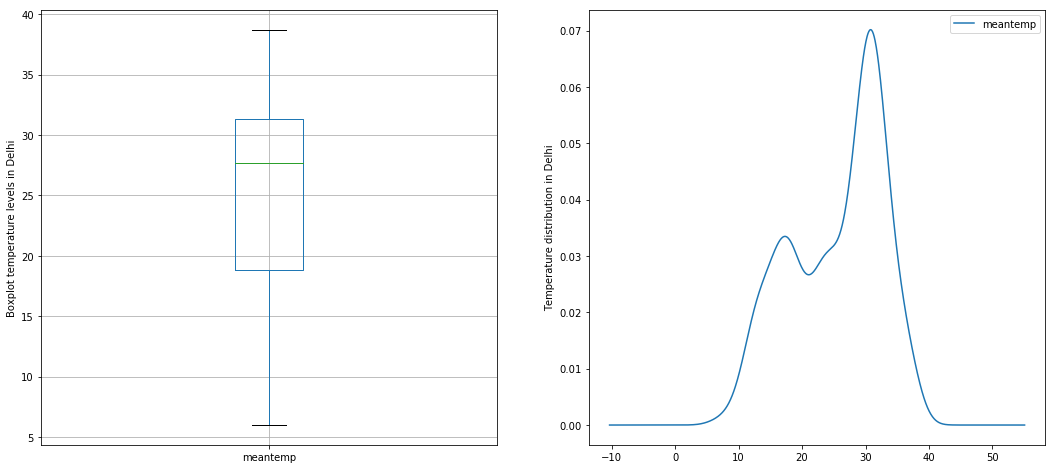

In [20]:
plotBoxNdendity(train_data,'meantemp')

#We can observe there are no outliers in box plot.



In [21]:
#Importing Arima libraries for model 

import seaborn as sns # for plot visualization
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [22]:
test_data.head()

,meantemp
date,
2017-01-01,15.913043
2017-01-02,18.500000
2017-01-03,17.111111
2017-01-04,18.700000
2017-01-05,18.388889


In [23]:
#resampling data to month wise for model generalization
train_data = train_data.resample('M').mean().fillna(method='pad')
test_data = test_data.resample('M').mean().fillna(method='pad')


In [24]:
test_data.head(5)

,meantemp
date,
2017-01-31,15.710873
2017-02-28,18.349981
2017-03-31,23.753760
2017-04-30,30.753663


In [25]:
#For every time series model, we will first convert data into stationary (constant mean and variance) before applying model
#For checking stationarity we test augmented dickey fuller test and check for p values
#if data is not stationary we will make it stationary with differencing (x{t}-x{t-1})
#if there is seasonality we do differencing with seasonal order.

In [26]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(temp):
    result=adfuller(temp)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [27]:
adfuller_test(train_data.meantemp)

ADF Test Statistic : 0.29190286702071194
p-value : 0.9769699297633487
#Lags Used : 10
Number of Observations Used : 37
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#Differencing

In [28]:
#As the data shows seasonality , we will shift by 12
train_data['Seasonal First Difference']=train_data['meantemp']-train_data['meantemp'].shift(12)

In [29]:
train_data.head(25)

,meantemp,Seasonal First Difference
date,,
2013-01-31,12.074770,NaN
2013-02-28,16.867560,NaN
2013-03-31,22.814209,NaN
2013-04-30,28.895119,NaN
2013-05-31,33.776767,NaN
2013-06-30,32.480873,NaN
2013-07-31,30.663594,NaN
2013-08-31,29.547773,NaN
2013-09-30,29.840595,NaN


In [30]:
## Again test dickey fuller test
adfuller_test(train_data['Seasonal First Difference'].dropna())

ADF Test Statistic : -4.138617961048752
p-value : 0.0008355617849947803
#Lags Used : 0
Number of Observations Used : 35
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [31]:
#Now the data is staionary, we will plot autocorrelation and partial autocorrelation plots to check for order of p,q, d 

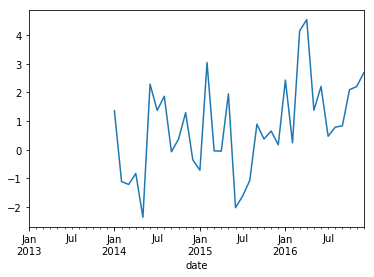

In [32]:
train_data['Seasonal First Difference'].plot()

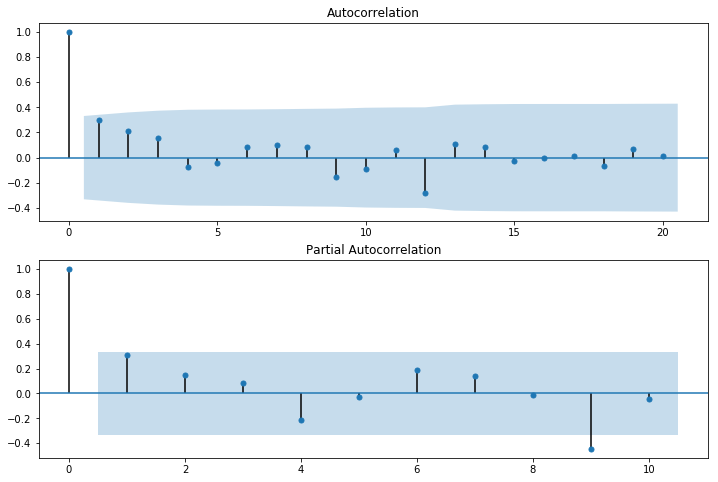

In [33]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_data['Seasonal First Difference'].iloc[13:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_data['Seasonal First Difference'].iloc[13:],lags=10,ax=ax2)


A partial autocorrelation is the amount of correlation between a variable and a lag of itself that is not explained by correlations at all lower-order-lags. The autocorrelation of a time series Y at lag 1 is the coefficient of correlation between Yt and Yt-1, which is presumably also the correlation between Yt-1 and Yt-2.the correlation at lag 1 "propagates" to lag 2 and presumably to higher-order lags.
The partial autocorrelation at lag 2 is therefore the difference between the actual correlation at lag 2 and the expected correlation due to the propagation of correlation at lag 1.

PACF is direct correlation between particular time period and current time period but ACF takes indirect effect of other factors , thus for AR we consider PACF

If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms.The lag at which the PACF cuts off is the indicated number of AR terms.



In [34]:
#p can be 2 or 3
#q can be 0 or 1
#d =1 as we have differenced the series once.
#model fitting
model1=sm.tsa.statespace.SARIMAX(train_data['meantemp'],order=(2, 1, 0),seasonal_order=(2,1,0,12))
results1=model1.fit()


In [35]:
#predicting for the test data
predictions_res1=results1.predict(start=len(train_data),end=len(train_data)+3,typ="levels")
#forecasting for next few months
forecast=results1.predict(start=len(train_data),end=len(train_data)+26,typ="levels")

In [36]:
type(forecast)
forecast_list=forecast.values
forecast_list

array([16.11558823, 19.94362822, 24.62334482, 31.10657674, 35.1743721 ,
       36.84578268, 34.20433798, 33.83398171, 33.0440011 , 29.61227087,
       23.34749247, 17.87901801, 16.66913677, 21.79263094, 26.16097521,
       32.77026484, 36.82861763, 36.64548753, 33.62632959, 33.6576856 ,
       33.94125656, 30.66472425, 24.58779354, 19.02345879, 18.44638045,
       22.36886946, 28.16031757])

In [37]:
coef = results1.params
coef


ar.L1      -0.326891
ar.L2      -0.061290
ar.S.L12   -0.952484
ar.S.L24   -0.564482
sigma2      1.243893
dtype: float64

In [38]:
rmse = sqrt(mean_squared_error(test_data['meantemp'], predictions_res1))
print('Test RMSE: %.3f' % rmse)
#order=(2, 1, 0),seasonal_order=(2,1,0,12) rmse is 0.947
print((test_data['meantemp'].mean()))

Test RMSE: 0.947
22.142069204660796


In [39]:
#for this model we have got rmse of 0.947 while the mean is 22.14 

In [40]:
test_data['predictions']=predictions_res1
test_data

,meantemp,predictions
date,,
2017-01-31,15.710873,16.115588
2017-02-28,18.349981,19.943628
2017-03-31,23.753760,24.623345
2017-04-30,30.753663,31.106577


Testing Observations: 4


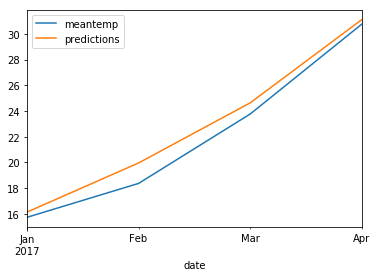

In [41]:
#potting actual test data and predicted test data
print('Testing Observations: %d' % (len(test_data)))
test_data[['meantemp','predictions']].plot()


In [42]:
#creating dates for forcasting the data 
from pandas.tseries.offsets import DateOffset
future_dates=[test_data.index[-1]+ DateOffset(months=x)for x in range(0,24)]


In [43]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=test_data.columns)

In [44]:
future_datest_df.head()

,meantemp,predictions
2017-05-30,NaN,NaN
2017-06-30,NaN,NaN
2017-07-30,NaN,NaN
2017-08-30,NaN,NaN
2017-09-30,NaN,NaN


In [45]:
#concat test data with future dates for plotting forcasted values
future_df=pd.concat([test_data,future_datest_df])
future_df.head()

,meantemp,predictions
2017-01-31,15.710873,16.115588
2017-02-28,18.349981,19.943628
2017-03-31,23.753760,24.623345
2017-04-30,30.753663,31.106577
2017-05-30,NaN,NaN


In [46]:
print(len(forecast_list))
print(len(future_df))
future_df['forecast']=forecast_list
future_df

27
27


,meantemp,predictions,forecast
2017-01-31,15.710873,16.115588,16.115588
2017-02-28,18.349981,19.943628,19.943628
2017-03-31,23.753760,24.623345,24.623345
2017-04-30,30.753663,31.106577,31.106577
2017-05-30,NaN,NaN,35.174372
2017-06-30,NaN,NaN,36.845783
2017-07-30,NaN,NaN,34.204338
2017-08-30,NaN,NaN,33.833982
2017-09-30,NaN,NaN,33.044001
2017-10-30,NaN,NaN,29.612271


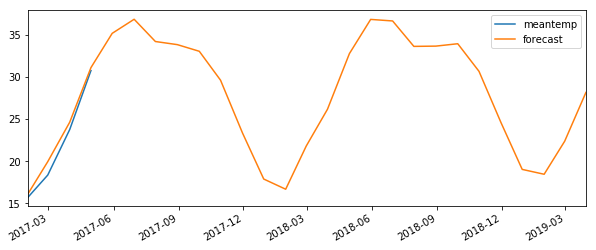

In [47]:

future_df[['meantemp', 'forecast']].plot(figsize=(10, 4)) 

# Auto Arima

##Using Auto Arima model which will automatically select p, q d values considering AIC value which should be minimum.

In [48]:
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [49]:
Sarimax_model = auto_arima(train_data['meantemp'],
                       start_P=1,
                       start_q=1,
                       max_p=3,
                       max_q=3,
                       m=12,
                       seasonal=True,
                       d=None,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
Sarimax_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=140.367, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=128.611, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=145.970, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=139.223, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=126.061, Time=0.86 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=128.004, Time=3.34 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=129.533, Time=0.28 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=128.057, Time=1.16 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=128.059, Time=1.12 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=127.619, Time=0.37 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=4.99 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=131.87

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 -58.030
Date:                            Sun, 04 Apr 2021   AIC                            126.061
Time:                                    18:16:42   BIC                            133.978
Sample:                                         0   HQIC                           128.824
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0620      0.400      2.657      0.008       0.279       1.845
ar.L1          0.4361      0.161      2.702      0.007       0.120       0.753
ar.S.L12      -1.0160      0.209     -4.854      0.000      -1.426      -0.606
ar.S.L24      -0.6040      0.204     -2.956      0.003      -1.004      -0.203
sigma2         0.9109      0.320      2.844      0.004       0.283       1.539
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.91   Prob(JB):                         0.80
Heteroskedasticity (H):               1.32   Skew:                             0.01
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
model = SARIMAX(train_data['meantemp'],order=(1, 0, 0),
              seasonal_order=(2, 1, 0, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results = model.fit()

In [51]:
#evaluating model on test data
predictions_res1 =results.predict(start = len(train_data),end=len(train_data)+len(test_data)-1,typ='levels')
rmse = sqrt(mean_squared_error(test_data['meantemp'], predictions_res1))
#print(predictions_res1)
print('Test RMSE: %.3f' % rmse)                           
                           

Test RMSE: 0.771


In [52]:
#forecasting data for future months

forecast = results.predict(start = len(train_data),end=len(train_data)+len(test_data)-1+36,typ='levels')
                           
                           
                           

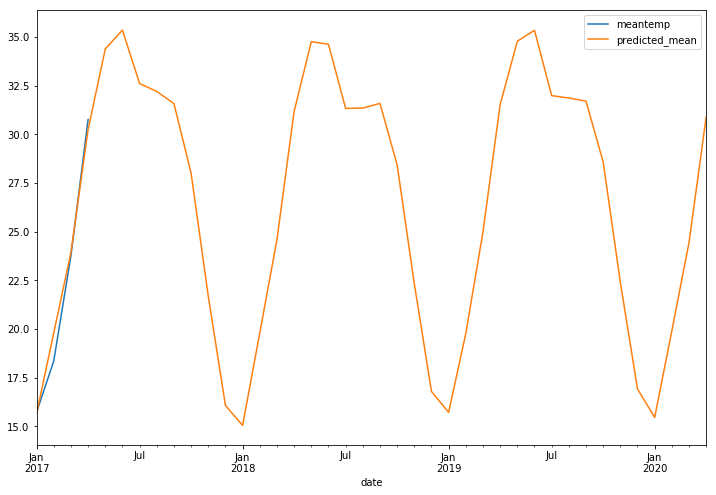

In [53]:
#plotting test data with forecast 
test_data['meantemp'].plot(figsize=(12,8),legend=True)
forecast.plot(legend=True)

#we can see our forecasted values have followed seasonal trend in predicting temparature over the years.

In [ ]:
import datetime
v=datetime.datetime.now()